# Generate the quantum circuit

In [2]:
# Import packages
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from ibm_quantum_widgets import draw_circuit
from qiskit_ionq import IonQProvider
import matplotlib
import pylatexenc

import qiskit
from qiskit import Aer
import numpy as np

## Generate quantum circuit

Use the probabilities and steps provided by the user to generate a quantum circuit.

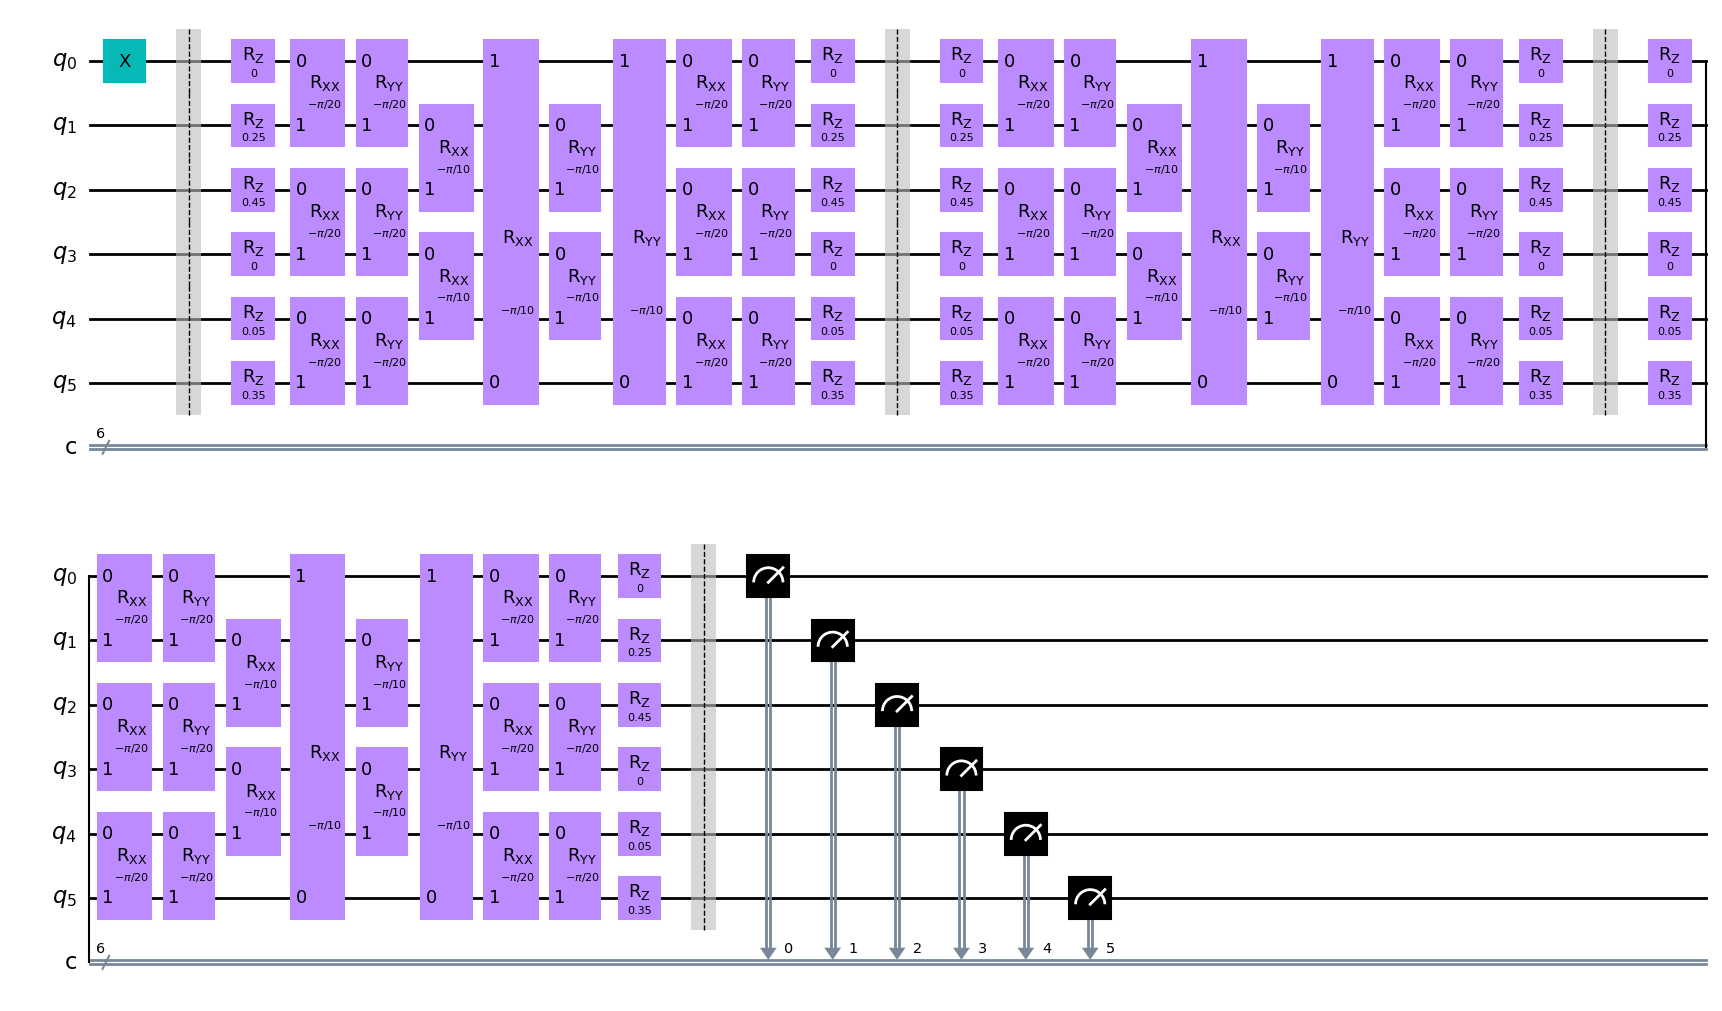

In [5]:
# JSON data example from the frontend
json_data = {
    "computer": "ionq",  # quantum computer to use
    "steps": 3,          # number of steps to take in the quantum circuit
    "places": [          # list of places to visit and their probabilities
        ["Home", 0.2],
        ["Opera", 0.5],
        ["Rooftop bar", 0.9],
        ["Street fair", 0.0],
        ["Pool", 0.1],
        ["Museum", 0.7],
    ]
}

# Retrieve probabilities
probabilities = []
for place in json_data['places']:
    probabilities.append(place[1])

# Quantum circuit variables
start = 0
probabilities[start] = 0
steps = json_data['steps']
J_val = np.pi / 10

# Define Qiskit parameters
L = len(probabilities)
J = Parameter('J')
K_i = []
for i in range(L):
    K_i.append(Parameter('K_'+str(i)))

# Define unitary
qc_U = QuantumCircuit(L)
qc_U.barrier()
for i in range(L):
    qc_U.rz(K_i[i]/2, i)
for i in range(L):
    if i % 2 == 0:
        qc_U.rxx(-J / 2, i % L, (i+1) % L)
        qc_U.ryy(-J / 2, i % L, (i+1) % L)
for i in range(L):
    if i % 2 != 0:
        qc_U.rxx(-J, i % L, (i+1) % L)
        qc_U.ryy(-J, i % L, (i+1) % L)
for i in range(L):
    if i % 2 == 0:
        qc_U.rxx(-J/2, i % L, (i+1) % L)
        qc_U.ryy(-J/2, i % L, (i+1) % L)
for i in range(L):
    qc_U.rz(K_i[i]/2, i)

# Compose main quantum circuit by duplicating the unitary circuit every step
qc_main = QuantumCircuit(L)
qc_main.x(start)
for step in range(steps):
    qc_main = qc_main.compose(qc_U, qubits=range(L))

# Add measurement circuit
qc_measure = QuantumCircuit(L, L)
qc_measure.measure_all(add_bits=False)
qc_end = qc_main.compose(qc_measure, range(L))

# Bind Qiskit parameters
qc_end = qc_end.bind_parameters({J: J_val})
for ind in range(L):
    qc_end = qc_end.bind_parameters({K_i[ind]: probabilities[ind]})

# Draw quantum circuit
# qc_end.draw()
qc_end.draw(output='mpl', filename='./circuit.png', vertical_compression=True)

In [6]:
# Transpile and run quantum circuit
simulator = Aer.get_backend('qasm_simulator')
backend = simulator

trans_circ = transpile(qc_end, backend)
job = backend.run(trans_circ)
results = job.result().get_counts()
results

{'000010': 307,
 '001000': 39,
 '100000': 219,
 '000100': 64,
 '000001': 323,
 '010000': 72}